In [1]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import StratifiedKFold
import statistics

import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from tqdm import tqdm
import copy
import pickle 
from multiprocessing import Pool

from utils import *

In [2]:
plt.rcParams['font.size'] = '16'
plt.rcParams['lines.linewidth'] = 6
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '20'
legend_font = '16'
title_font = '24'

color_palette = ["#e07a5f","#3d405b","#81b29a","#f2cc8f","#98c1d9","#457b9d","#c74546","#613f75"]
gray = '#8b96ad'
red = '#c74546'
dark = 'k'

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(color_palette))

# Load data and QC

In [30]:
adata = ad.read_h5ad('/home/mffang/data/counts/10x/pbmc_3pv3/rna/counts_filtered/adata.h5ad')
adata

AnnData object with n_obs × n_vars = 11959 × 39583
    layers: 'ambiguous', 'mature', 'nascent'

In [31]:
adata.var['gene_id'] = adata.var_names
adata.var_names = [g.split('.')[0] for g in adata.var_names]
adata.var

,gene_id
ENSG00000228037,ENSG00000228037.1
ENSG00000142611,ENSG00000142611.17
ENSG00000284616,ENSG00000284616.1
ENSG00000157911,ENSG00000157911.11
ENSG00000260972,ENSG00000260972.1
...,...
ENSG00000275063,ENSG00000275063.1
ENSG00000277856,ENSG00000277856.1
ENSG00000271254,ENSG00000271254.7
ENSG00000268674,ENSG00000268674.2


/tmp/ipykernel_4136869/259953683.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


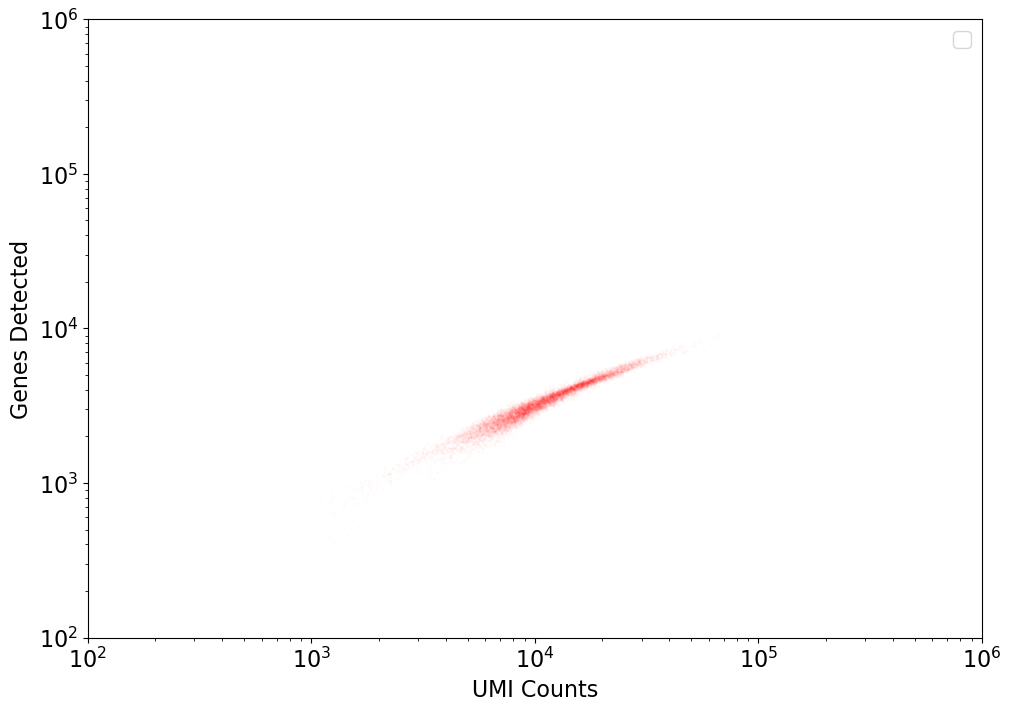

In [6]:
adata.X = adata.layers['ambiguous']+adata.layers['mature']+adata.layers['nascent']

fig, ax = plt.subplots(figsize=(10, 7))

mtx = adata.X
ax.scatter(np.asarray(mtx.sum(axis=1)), np.asarray(np.sum(mtx>0, axis=1)), color="red", s=1, alpha=0.01)

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((1e2,1e6))
ax.set_ylim((1e2,1e6))

plt.legend()

In [7]:
statistics.median(mtx.sum(axis=1))

matrix([[10188.]])

# Clustering

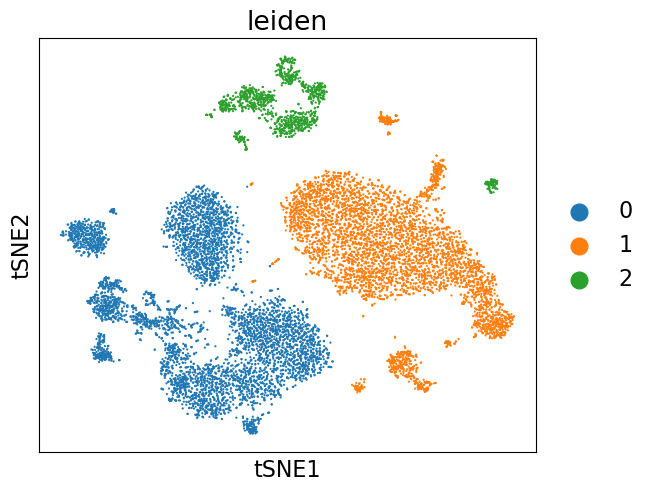

In [42]:
data = adata.copy()

# preprocessing 
sc.pp.filter_genes(data, min_cells=3)

sc.pp.normalize_total(data)
sc.pp.log1p(data)

sc.pp.highly_variable_genes(data, n_top_genes=2000)

# PCA and neighborhood graph
sc.tl.pca(data)
sc.pp.neighbors(data)
sc.tl.umap(data)
sc.tl.tsne(data)

# Clustering and t-SNE
sc.tl.leiden(data,resolution=0.01)
sc.pl.tsne(data, color=["leiden"])

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


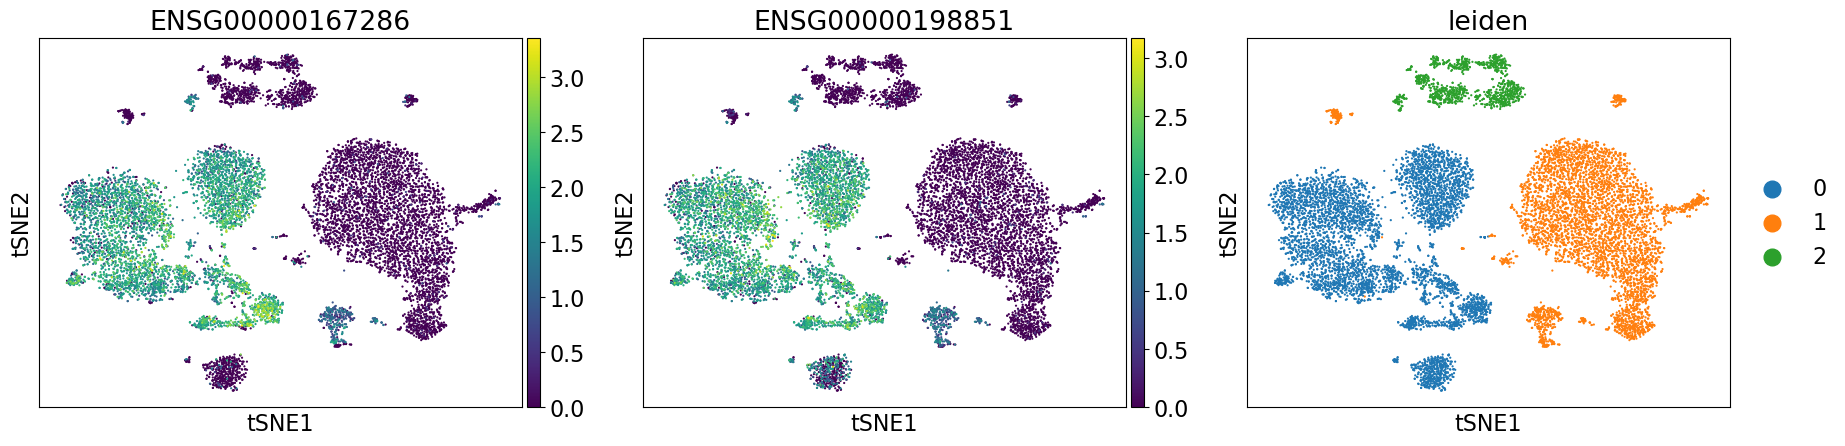

In [9]:
# T Cell
sc.pl.tsne(data,color=['ENSG00000167286','ENSG00000198851',"leiden"])

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


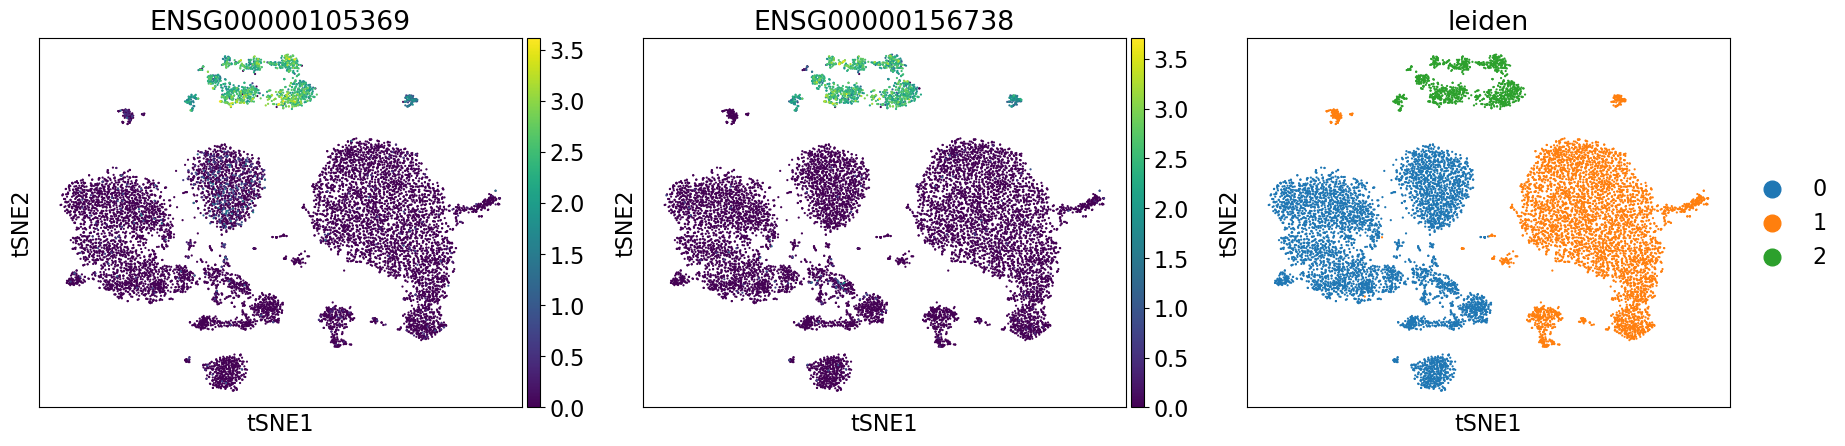

In [10]:
# B cells
sc.pl.tsne(data,color=['ENSG00000105369','ENSG00000156738',"leiden"])

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


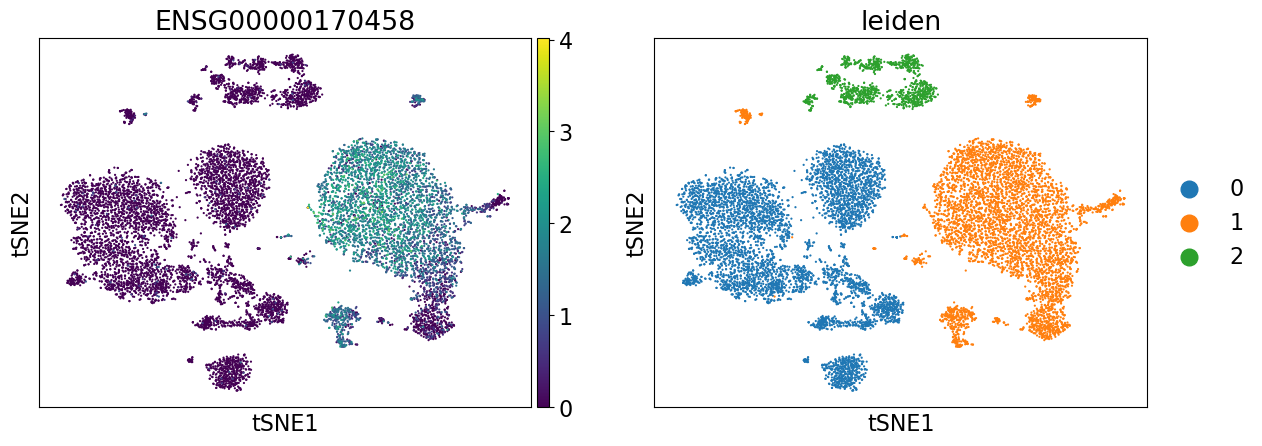

In [11]:
# Monocyte cells
sc.pl.tsne(data,color=['ENSG00000170458',"leiden"])

# Calculate normalized covariance

0.10335306402087316 0.06505954857844404 0.13579236422047872


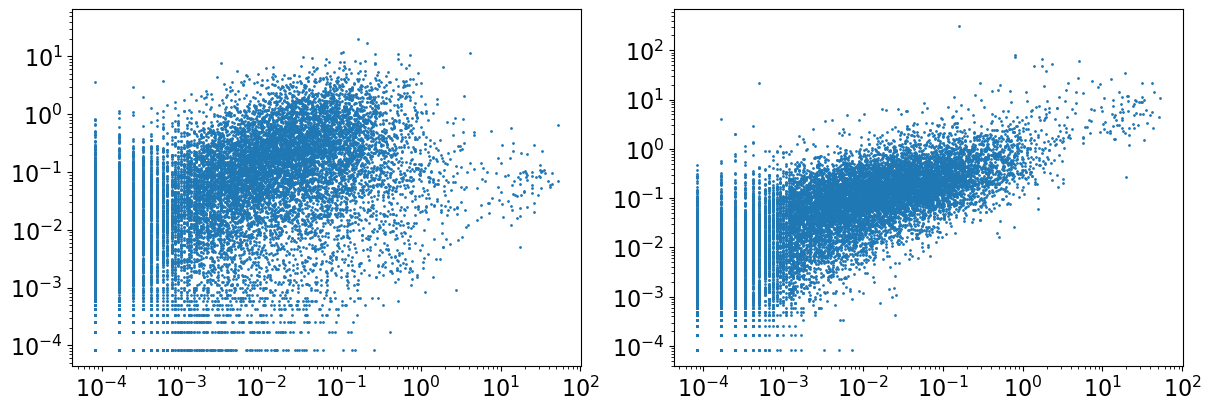

In [12]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['mature'].toarray().mean(0),adata.layers['nascent'].toarray().mean(0),s=1)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(adata.layers['mature'].toarray().mean(0),adata.layers['ambiguous'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
print(adata.layers['nascent'].toarray().mean(),adata.layers['mature'].toarray().mean(),adata.layers['ambiguous'].toarray().mean())

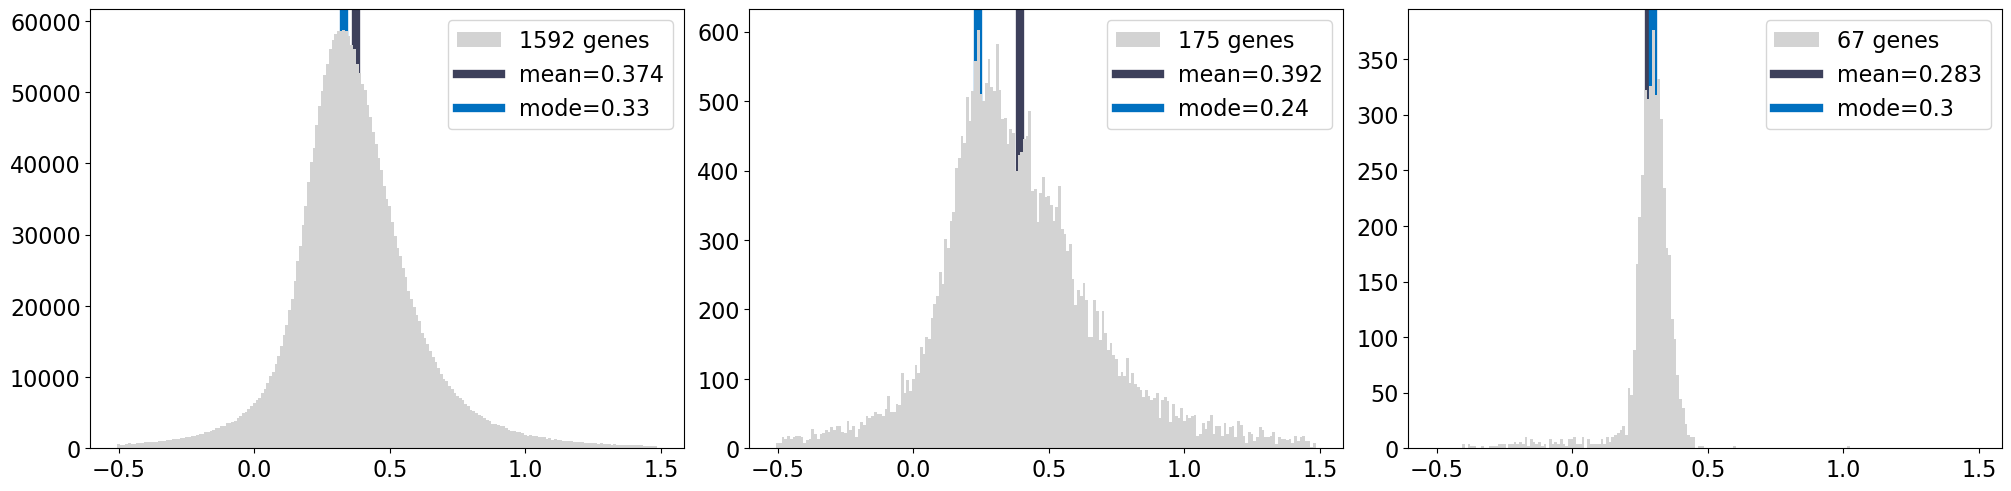

In [8]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[0],min_mean=0.1,max_mean=1)
s = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[1],min_mean=1,max_mean=10)
s = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[2],min_mean=10)

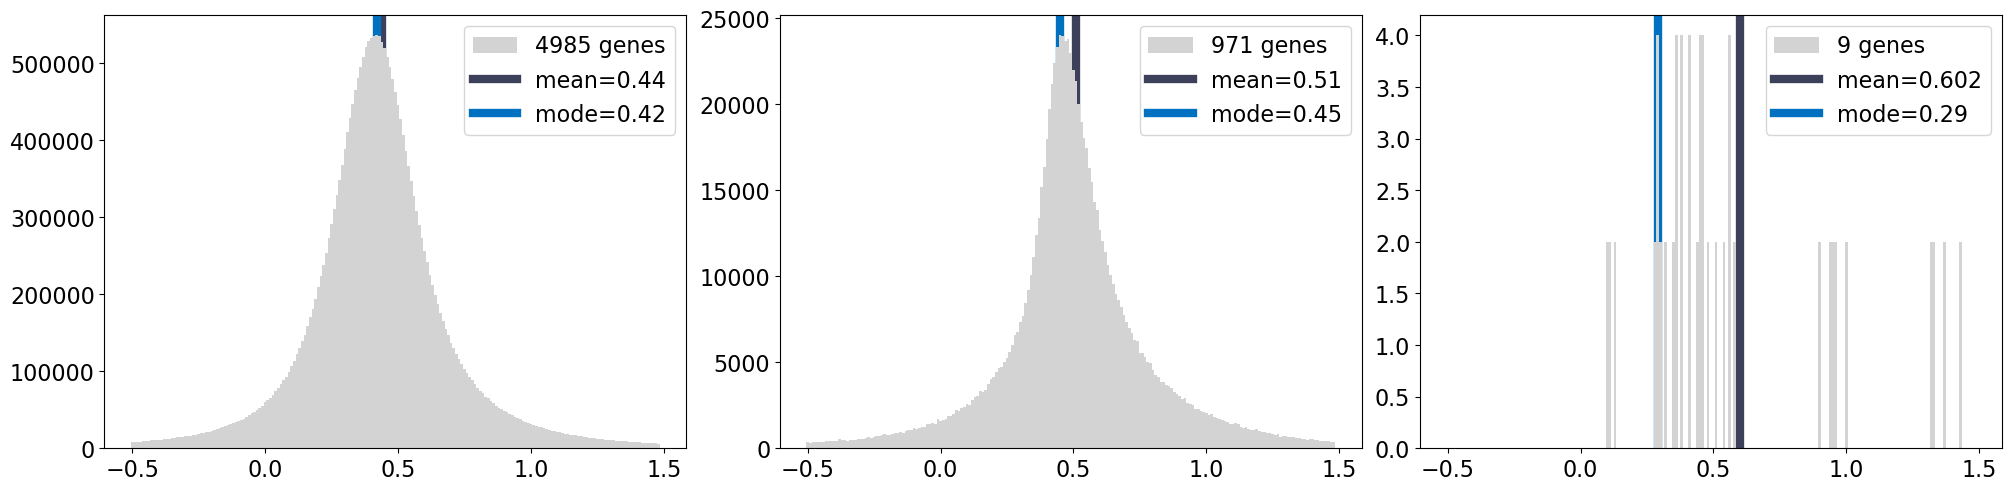

In [9]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s = estimate_s(N1=adata.layers["nascent"].toarray(),ax=axs[0],min_mean=0.1,max_mean=1)
s = estimate_s(N1=adata.layers["nascent"].toarray(),ax=axs[1],min_mean=1,max_mean=10)
s = estimate_s(N1=adata.layers["nascent"].toarray(),ax=axs[2],min_mean=10)

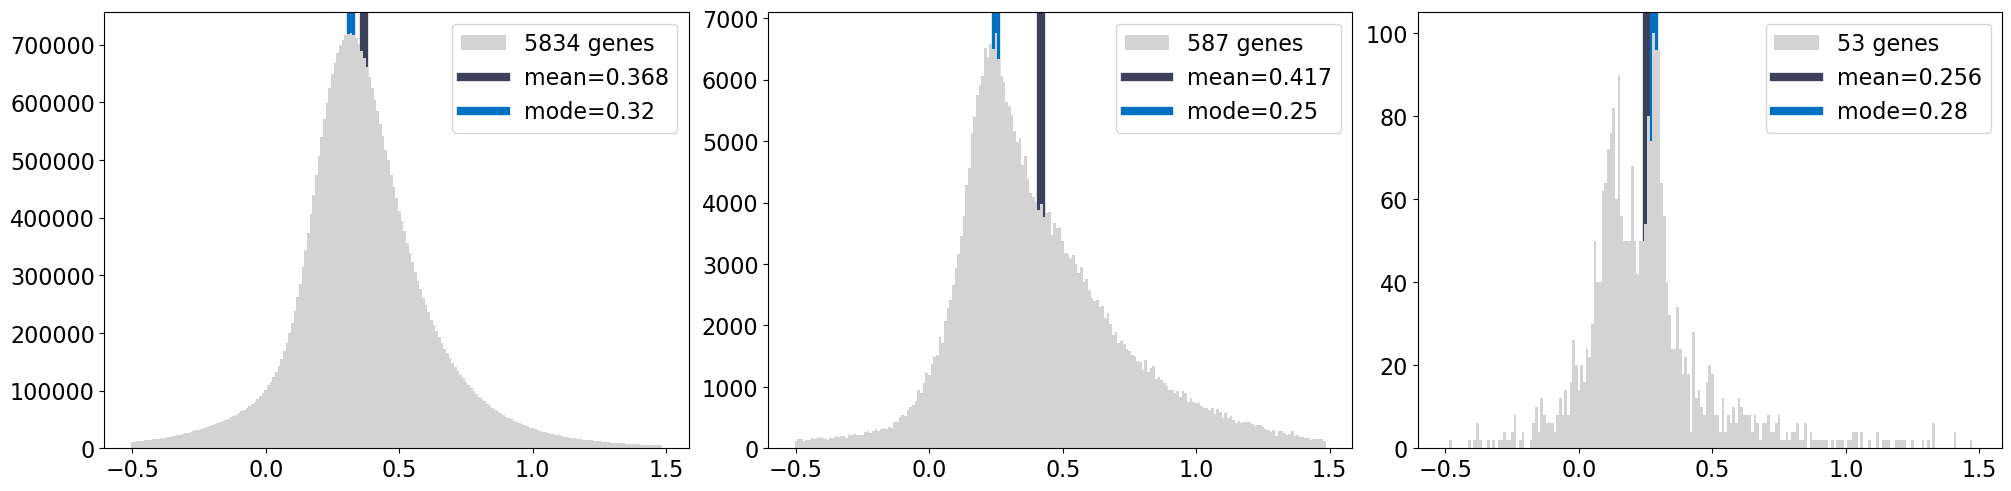

In [10]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s = estimate_s(N1=adata.layers["ambiguous"].toarray(),ax=axs[0],min_mean=0.1,max_mean=1)
s = estimate_s(N1=adata.layers["ambiguous"].toarray(),ax=axs[1],min_mean=1,max_mean=10)
s = estimate_s(N1=adata.layers["ambiguous"].toarray(),ax=axs[2],min_mean=10,max_mean=np.inf)

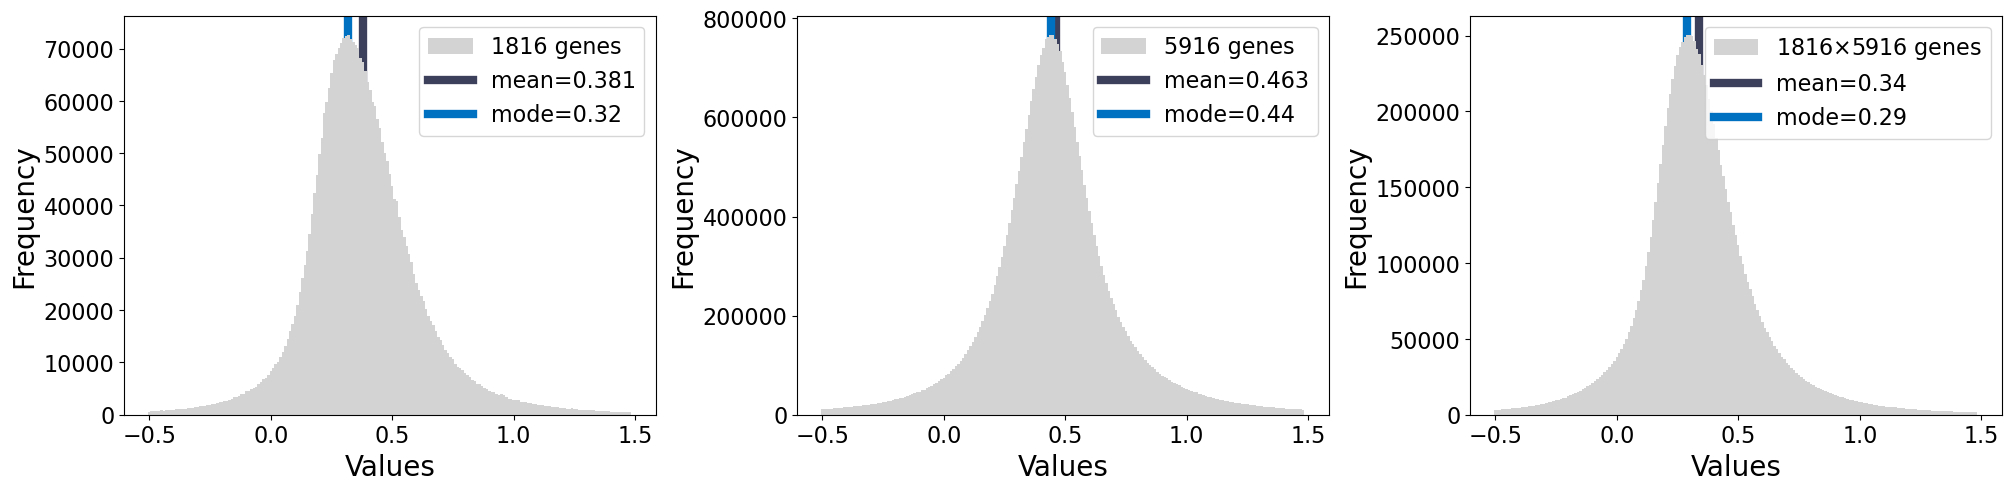

In [13]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s_mm = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[0],min_mean=0.1)
s_nn = estimate_s(N1=adata.layers["nascent"].toarray(),ax=axs[1],min_mean=0.1)
s_nn = estimate_s(N1=adata.layers["mature"].toarray(),N2=adata.layers["nascent"].toarray(),ax=axs[2],min_mean=0.1)

for i in range(len(axs)):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

# Select Poisson genes by normalized variance

In [57]:
X_ = adata.layers['mature'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]

lower_bound, upper_bound, eta_bootstrap = bootstrapping_func(normalized_variance,[X_],B=1000,n_cores=50)

Text(0.5, 0, 'Values')

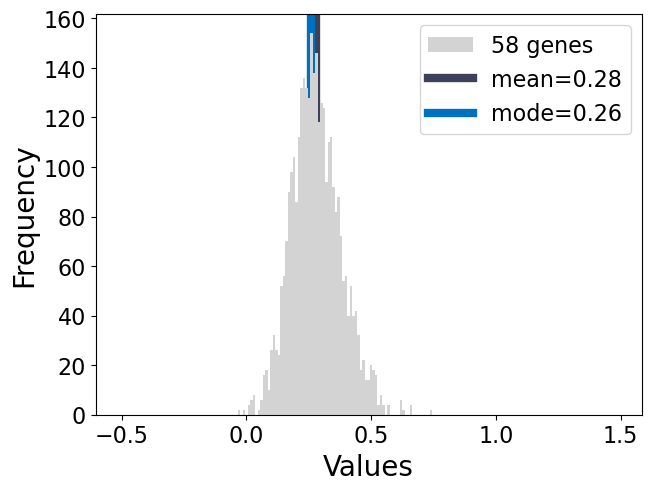

In [59]:
s = 0.28

S_Pgene_mask = (s < upper_bound) & (s > lower_bound) 
S_Pgene = adata.var_names[nonzero_idx][S_Pgene_mask]

fig,axs = plt.subplots(1,1)

idx = adata.var_names.isin(S_Pgene)
X_S = adata.layers['mature'].toarray()[:,idx]
_ = estimate_s(X_S,ax=axs)

axs.set_ylabel('Frequency',fontsize=20)
axs.set_xlabel('Values',fontsize=20)

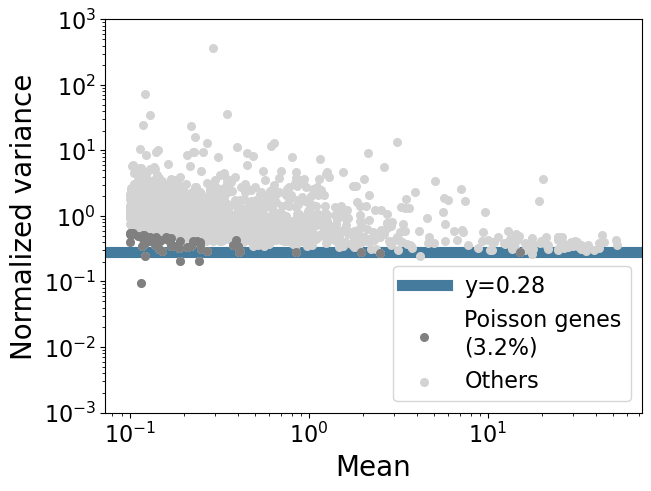

In [60]:
X_ = adata.layers['mature'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
Pgene_mask = S_Pgene_mask.copy()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-3,1e3])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Normalized variance',fontsize=20);
ax.legend(loc='lower right',fontsize=16);

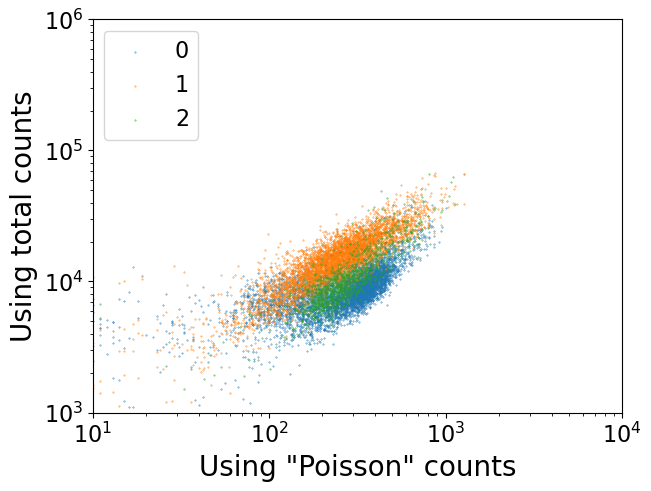

In [49]:
# Preprocessing
X_ = adata.layers["mature"].toarray().copy()
nonzero_idx = X_.mean(0) > 0.1
X_ = X_[:, nonzero_idx]
cellsize_S = X_[:, S_Pgene_mask].sum(1)
cellsize_X = adata.X.toarray().copy().sum(1)

# Extract class labels
class_labels = data.obs["leiden"]

# Map unique labels to distinct colors
unique_labels = np.sort(np.array(class_labels.unique()))
color_map = dict(zip(unique_labels, plt.cm.tab10.colors[:len(unique_labels)]))  # Choose a colormap

# Plot
fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8))
for label in unique_labels:
    idx = class_labels == label
    ax.scatter(
        cellsize_S[idx], 
        cellsize_X[idx], 
        s=0.1, 
        color=color_map[label], 
        label=label
    )
 
ax.set_ylim((1e3,1e6))
ax.set_xlim((1e1,1e4))

# Set log-log scale
ax.set_xscale('log')
ax.set_yscale('log')

# Add legend and labels
plt.legend(loc="upper left", fontsize=16)
plt.xlabel('Using "Poisson" counts', fontsize=20)
plt.ylabel('Using total counts', fontsize=20)
plt.show()

Text(0, 0.5, 'All counts')

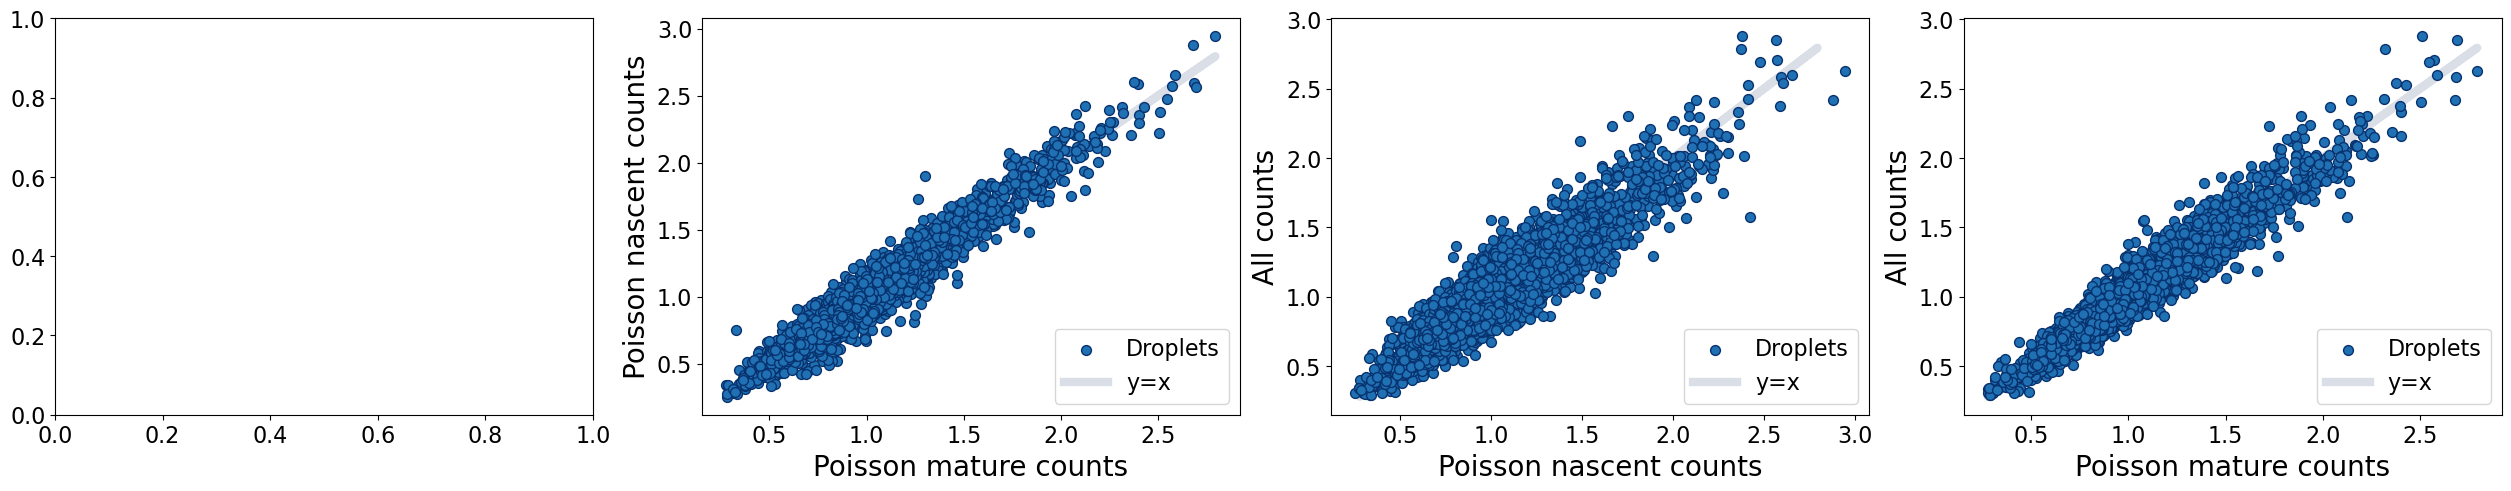

In [36]:
fig,ax = plt.subplots(1,4,figsize=(25,4.8))
ax[1].scatter(cellsize_S/cellsize_S.mean(),cellsize_U/cellsize_U.mean(),color='#2070b4',edgecolor='#08326e',alpha=1,s=50,label='Droplets')
ax[1].plot(cellsize_S/cellsize_S.mean(),cellsize_S/cellsize_S.mean(),zorder=0,color='#d9dee7',label='y=x')
ax[1].legend(loc='lower right',fontsize=16)
ax[1].set_xlabel('Poismon mature counts',fontsize=20)
ax[1].set_ylabel('Poismon nascent counts',fontsize=20)

ax[2].scatter(cellsize_U/cellsize_U.mean(),cellsize_X/cellsize_X.mean(),color='#2070b4',edgecolor='#08326e',alpha=1,s=50,label='Droplets')
ax[2].plot(cellsize_S/cellsize_S.mean(),cellsize_S/cellsize_S.mean(),zorder=0,color='#d9dee7',label='y=x')
ax[2].legend(loc='lower right',fontsize=16)
ax[2].set_xlabel('Poismon nascent counts',fontsize=20)
ax[2].set_ylabel('All counts',fontsize=20)

ax[3].scatter(cellsize_S/cellsize_S.mean(),cellsize_X/cellsize_X.mean(),color='#2070b4',edgecolor='#08326e',alpha=1,s=50,label='Droplets')
ax[3].plot(cellsize_S/cellsize_S.mean(),cellsize_S/cellsize_S.mean(),zorder=0,color='#d9dee7',label='y=x')
ax[3].legend(loc='lower right',fontsize=16)
ax[3].set_xlabel('Poismon mature counts',fontsize=20)
ax[3].set_ylabel('All counts',fontsize=20)

# Check covariance relationships

In [29]:
idx = adata.var_names.isin(adata.var_names)

N = adata.layers["nascent"][:,idx].toarray()
M = adata.layers["mature"][:,idx].toarray() 

idx = (N.mean(0)>0.1) & (M.mean(0)>0.1)
N = N[:,idx]
M = M[:,idx]

M_mean = np.mean(M,axis=0)
N_mean = np.mean(N,axis=0)

M_var = np.var(M,axis=0)
N_var = np.var(N,axis=0)

zeta_nn = (N_var-N_mean)/N_mean**2
zeta_mm = (M_var-M_mean)/M_mean**2

cov_nm = []
for i in np.arange(len(N_mean)):
    cov_nm.append(np.cov(N[:,i],M[:,i])[0,1])
    
zeta_nm = np.array(cov_nm)/M_mean/N_mean
zeta_nm.shape

(1120,)

## Var(N)

Text(0.5, 1.0, '100.0% of cells >= 0')

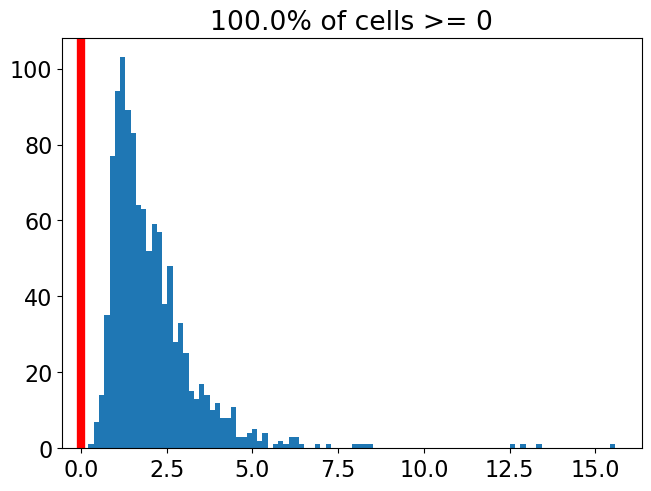

In [22]:
plt.hist(zeta_nn,bins=100);
plt.axvline(x=0,c='r',zorder=0)
plt.title(str(np.around(100*(zeta_nn>=0).mean(),2))+'% of cells >= 0')

## Cov(N,M)
$$\zeta_{us}<\zeta_{uu}$$

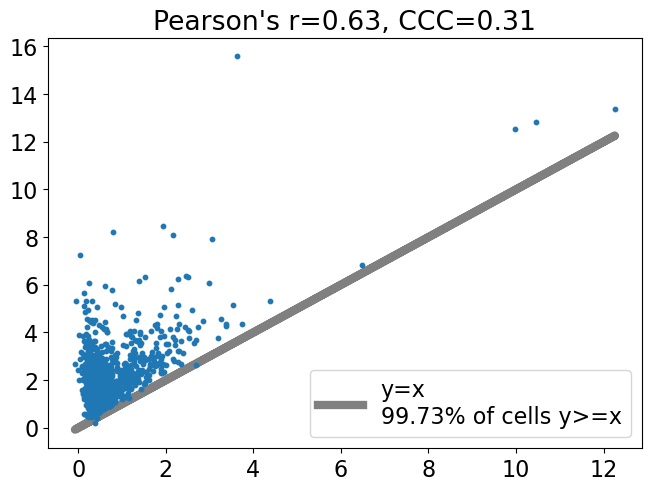

In [23]:
x=zeta_nm
y=zeta_nn

plt.plot(x,x,color='gray',zorder=0,label='y=x\n'+str(np.around(100*(x<=y).mean(),2))+'% of cells y>=x')
#plt.plot(x,x*2,zorder=0,label='y=0.5x (beta=gamma))\n'+str(np.around(100*(x*2<=y).mean(),2))+'% of cells y>=2x')
plt.scatter(x,y,s=10,alpha=1)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
#plt.colorbar(label=r'1/E[$N_s$]')
plt.legend()

## Var(M)

$$\zeta_{nm}=\zeta_{mm}$$

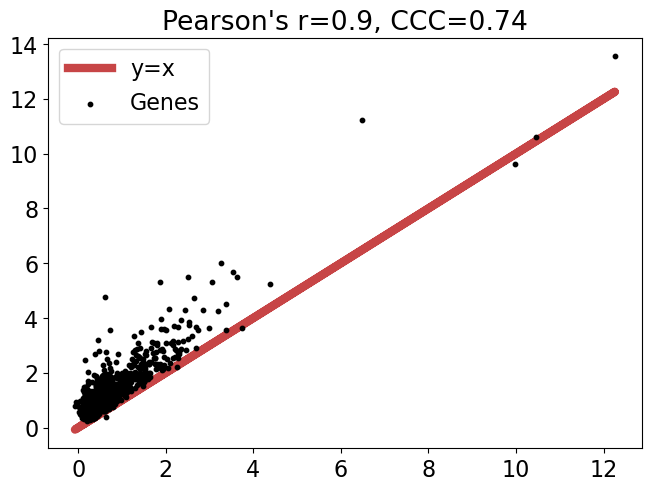

In [24]:
x=zeta_nm
y=zeta_mm

plt.plot(x,x,zorder=0,c=red,label='y=x')
#plt.plot(x,x*2,zorder=0,label='y=0.5x (beta=gamma))\n'+str(np.around(100*(x*2<=y).mean(),2))+'% of cells y>=2x')
plt.scatter(x,y,s=10,label='Genes',color=dark)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
#plt.colorbar(label=r'1/E[$X^m$]')
plt.legend()

In [25]:
lower_bound, upper_bound, delta_eta_bootstrap = bootstrapping_func(delta_eta,[N,M],B=1000,n_cores=50)
Null_gene_mask = (0 < upper_bound) & (0 > lower_bound) 
Null_gene_mask.mean()

0.09642857142857143

Pearson's r=0.904, CCC=0.735


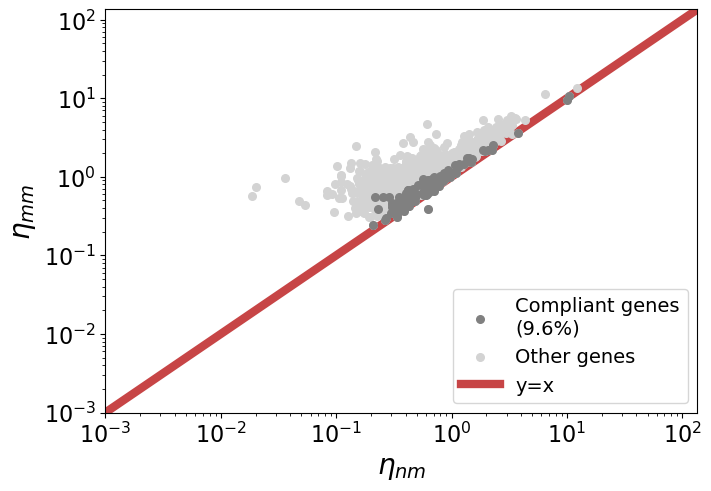

In [26]:
x=zeta_nm
y=zeta_mm

all_data = np.concatenate([x, y])
min_val, max_val = 1e-3, all_data.max()*10

plt.figure(figsize=(7,4.8))
plt.scatter(x[Null_gene_mask],y[Null_gene_mask],s=30,zorder=2,color='gray',label='Compliant genes\n('+str(np.around(100*np.mean(Null_gene_mask),1))+"%)")
plt.scatter(x,y,s=30,color='lightgray',zorder=1,label='Other genes')
plt.loglog([min_val, max_val],[min_val, max_val],zorder=0,c=red,label='y=x')
plt.legend(loc='lower right',fontsize=14);
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.xlabel(r'$\eta_{nm}$',fontsize=20);
plt.ylabel(r'$\eta_{mm}$',fontsize=20);
#plt.savefig(figprefix+"_us.pdf", dpi=150)
print("Pearson's r="+str(np.round(pearsonr(x,y).statistic,3))+", CCC="+str(np.round(CCC(x,y),3)))